# Restricted Boltzman Machines

Un RBM est un algorithme non-linéaire et non-supervisé qui est basé sur un modèle probabiliste.  Son but est d'apprendre des critères.  Souvent, on suit avec un classifieur comme SVM ou perceptron.  On l'utilise également pour initialiser les poids d'un réseau deep, ce qui s'appelle "_unsupervised pre-training_".

Modèle probabiliste, il se base sur la distribution des données à l'entrée.

Scikit-learn ne propose que `BernoulliRBM`, où les entrées sont binaires : 0 ou 1 : la probabilité que le critère est présent (est positif).  L'utilité sur les petits ensembles est limité, mais il n'y a pas de règle facile pour définir "petit".

## Reconnaissance de chiffres

Un pixel d'une image en niveau de gris représente (peut représenter?) la probabilité que le pixel soit noir ou blanc.

Pour avoir un ensemble de donner plus important, nous générons artificiellement plus de données étiquetées avec une perturbation d'un pixel dans chaque direction.

Discussion :
* Le monde probabiste
* Convolution
* Perturbation


Restricted Boltzmann Machine features for digit classification

For greyscale image data where pixel values can be interpreted as degrees
of blackness on a white background, like handwritten digit recognition,
the Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data
with linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a
BernoulliRBM feature extractor and a :class:`LogisticRegression
<sklearn.linear_model.LogisticRegression>` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here
because of runtime constraints.

Logistic regression on raw pixel values is presented f

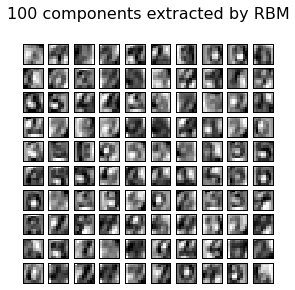

In [3]:
"""
==============================================================
Restricted Boltzmann Machine features for digit classification
==============================================================

For greyscale image data where pixel values can be interpreted as degrees
of blackness on a white background, like handwritten digit recognition,
the Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data
with linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a
BernoulliRBM feature extractor and a :class:`LogisticRegression
<sklearn.linear_model.LogisticRegression>` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here
because of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The
example shows that the features extracted by the BernoulliRBM help improve
the classification accuracy.
"""

from __future__ import print_function

print(__doc__)

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


###############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, Y_train)

###############################################################################
# Evaluation

print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        classifier.predict(X_test))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        logistic_classifier.predict(X_test))))

###############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()